# Gaussian Process (GP) Regression Models

This section provides implementation for concepts related to gaussian process based models. The first block of code imports the required packages and methods:

> __*NOTE*__: A few notes for this section. Make sure to go through these before proceeding to run the code for this section.
* This section requires the `gpytorch` and `botorch` packages. To install both of them, it is sufficient to run `pip install botorch` as `gpytorch` will be installed as a dependency while installing `botorch`.
* Remember to make sure that you have downloaded and installed the latest release of the `scimlstudio` package before running the code in this section.
* You may see a TqdmWarning when importing the packages. This can be safely ignored.


In [17]:
import numpy as np
import torch
from scimlstudio.models import SingleOutputGP
from scimlstudio.utils import Standardize, Normalize
import gpytorch
from gpytorch.kernels import MaternKernel, RQKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
import matplotlib.pyplot as plt
from scimlstudio.utils.evaluation_metrics import evaluate_scalar # importing to calculate nrmse metric

# Defining the device and data types
tkwargs = {"device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'), "dtype": torch.float64}

Forrester function (given below and also used in the RBF and polynomial sections) will be used for demonstration.

$$
y(x) = (6x - 2)^2\sin(12x-4) \\
0 \leq x \leq 1
$$

Below block of code defines this function:

In [18]:
forrester = lambda x: (6*x-2)**2*torch.sin(12*x-4)

Below block of code creates training dataset consists of 4 equally spaced points and creates a testing dataset of 100 equally spaced points:

In [19]:
# Training data
xtrain = torch.linspace(0, 1, 4, **tkwargs)
ytrain = forrester(xtrain)

# Plotting data
xtest = torch.linspace(0, 1, 100, **tkwargs)
ytest = forrester(xtest)

The GP model is created using `scimlstudio` package. To create the model, the `SingleOutputGP` class must be used. This class implements a single output GP model using the `GPyTorch` and `BoTorch` libraries. Following are the important input parameters for the `SingleOutputGP` class:

* `x_train`: A 2D tensor array containing the training inputs with shape (N, d)
* `y_train`: A 2D tensor array containing the training outputs with shape (N, 1)
* `likelihood_module`: Likelihood function for the GP model. Default is a Gaussian likelihood function with a log normal prior.
* `mean_module`: Mean function for the GP model. Default is a constant mean function.
* `covar_module`: Covariance function for the GP model. Default uses the radial basis (exponential) kernel function with a log normal prior scaled according to the dimensionality of the input data.

> __*NOTE*__: The default likelihood and kernel functions are recent developments within GP model research that aim to improve the performance of GP models for high-dimensional problems. To learn more about these functions, refer to the original paper available [here](https://arxiv.org/abs/2402.02229). When using these functions, it is also recommended to normalize the input variables and standardize the output variables.

The marginal log likelihood is used as a loss function to train the model. Adam, a gradient descent algorithm with momentum, is used to optimize the hyperparameters of the model based on the generated training data. Further details about the Adam optimization algorithm can be found in the original [paper](https://arxiv.org/abs/1412.6980) and a simplified explaination of it can be found at this [link](https://jamhuri.medium.com/understanding-the-adam-optimization-algorithm-a-deep-dive-into-the-formulas-3ac5fc5b7cd3). Below block of code creates the model using **radial basis (exponential)** kernel function with dimension scaled prior and plots the prediction:

Optimal lengthscale value: 0.12155060470104218


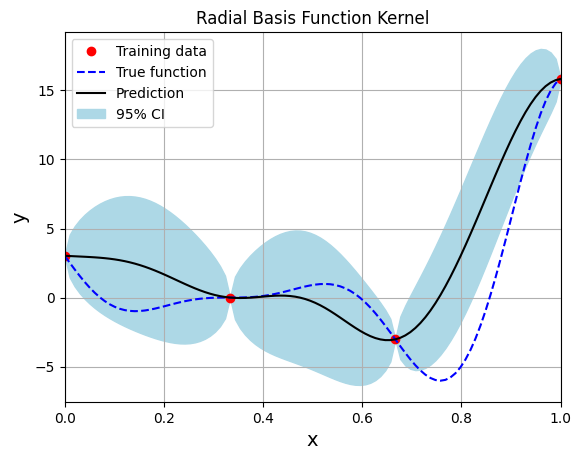

In [20]:
# Create model
gp = SingleOutputGP(x_train=xtrain.reshape(-1,1), y_train=ytrain.reshape(-1,1), output_transform=Standardize, input_transform=Normalize)

# Defining a few things to train the model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # loss function 
optimizer = torch.optim.Adam(gp.parameters(), lr=0.01) # optimizer

# Training the model
gp.fit(training_iterations=1000, mll=mll, optimizer=optimizer)

print(f"Optimal lengthscale value: {gp.covar_module.base_kernel.lengthscale.item()}")

# Prediction for plotting
ytest_pred, ytest_std = gp.predict(xtest.reshape(-1,1))

# Plotting
fig, ax = plt.subplots()
ax.plot(xtrain.numpy(force=True), ytrain.numpy(force=True), 'ro', label='Training data')
ax.plot(xtest.numpy(force=True), ytest.numpy(force=True), 'b--', label='True function')
ax.plot(xtest.numpy(force=True), ytest_pred.numpy(force=True), 'k', label='Prediction')
ax.fill_between(xtest.numpy(force=True), ytest_pred.reshape(-1,).numpy(force=True) - 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), 
                ytest_pred.reshape(-1,).numpy(force=True) + 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), color='lightblue', label='95% CI')
ax.set_xlim([0, 1])
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Radial Basis Function Kernel")
ax.legend()
ax.grid()

Few important points to note:
- Gaussian process regression is an interpolating model as it passes through the training points.
- Model provides a mean prediction and an uncertainty estimate in the prediction.
- The training procedure aims to find the best lengthscale for the kernel function given the training data. 

Below block of code creates the model using the **Matern** kernel function with the smoothness parameter set to 2.5:

Optimal lengthscale value: 0.11899595707654953


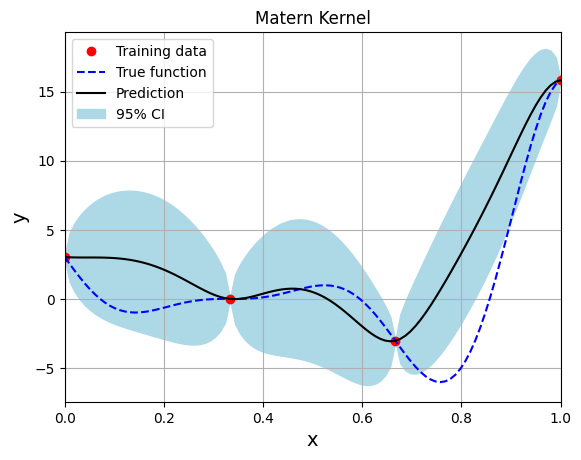

In [21]:
# Create model
gp = SingleOutputGP(x_train=xtrain.reshape(-1,1), y_train=ytrain.reshape(-1,1), covar_module=MaternKernel, output_transform=Standardize, input_transform=Normalize)

# Defining a few things to train the model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # loss function 
optimizer = torch.optim.Adam(gp.parameters(), lr=0.01) # optimizer

# Training the model
gp.fit(training_iterations=1000, mll=mll, optimizer=optimizer)

print(f"Optimal lengthscale value: {gp.covar_module.base_kernel.lengthscale.item()}")

# Prediction for plotting
ytest_pred, ytest_std = gp.predict(xtest.reshape(-1,1))

# Plotting
fig, ax = plt.subplots()
ax.plot(xtrain.numpy(force=True), ytrain.numpy(force=True), 'ro', label='Training data')
ax.plot(xtest.numpy(force=True), ytest.numpy(force=True), 'b--', label='True function')
ax.plot(xtest.numpy(force=True), ytest_pred.numpy(force=True), 'k', label='Prediction')
ax.fill_between(xtest.numpy(force=True), ytest_pred.reshape(-1,).numpy(force=True) - 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), 
                ytest_pred.reshape(-1,).numpy(force=True) + 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), color='lightblue', label='95% CI')
ax.set_xlim([0, 1])
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Matern Kernel")
ax.legend()
ax.grid()

Below block of code creates the model using the **Rational Quadratic** kernel function: 

Optimal lengthscale value: 0.10978628695011139


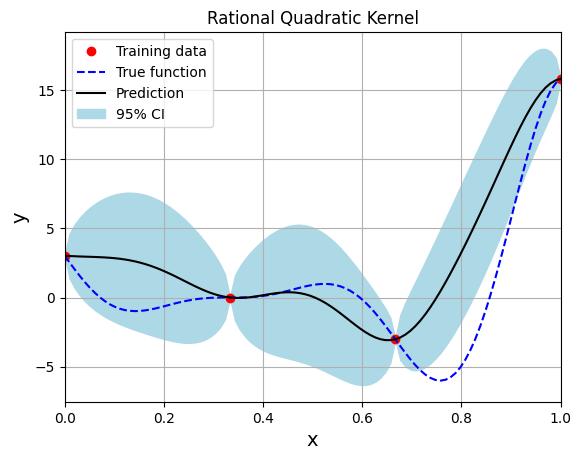

In [22]:
# Create model
gp = SingleOutputGP(x_train=xtrain.reshape(-1,1), y_train=ytrain.reshape(-1,1), covar_module=RQKernel, output_transform=Standardize, input_transform=Normalize)

# Defining a few things to train the model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # loss function 
optimizer = torch.optim.Adam(gp.parameters(), lr=0.01) # optimizer

# Training the model
gp.fit(training_iterations=1000, mll=mll, optimizer=optimizer)

print(f"Optimal lengthscale value: {gp.covar_module.base_kernel.lengthscale.item()}")

# Prediction for plotting
ytest_pred, ytest_std = gp.predict(xtest.reshape(-1,1))

# Plotting
fig, ax = plt.subplots()
ax.plot(xtrain.numpy(force=True), ytrain.numpy(force=True), 'ro', label='Training data')
ax.plot(xtest.numpy(force=True), ytest.numpy(force=True), 'b--', label='True function')
ax.plot(xtest.numpy(force=True), ytest_pred.numpy(force=True), 'k', label='Prediction')
ax.fill_between(xtest.numpy(force=True), ytest_pred.reshape(-1,).numpy(force=True) - 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), 
                ytest_pred.reshape(-1,).numpy(force=True) + 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), color='lightblue', label='95% CI')
ax.set_xlim([0, 1])
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Rational Quadratic Kernel")
ax.legend()
ax.grid()

Note that mean prediction and uncertainty estimates are slightly different for different kernel functions and you need to experiment with different kernel functions to find the best model for your problem. Now, number of samples will be increased to see when model prediction is good. This method is also known as **one-shot sampling**. More efficient way to obtain good fit is to use sequential sampling which will be discussed in future sections. Below block of code fits the GP model with radial basis function kernel on different sample sizes, plots the fit, and computes normalized RMSE on testing data.

Optimal lengthscale value for 3 samples: 0.1656428724527359
Optimal lengthscale value for 4 samples: 0.12155060470104218
Optimal lengthscale value for 5 samples: 0.08893626183271408
Optimal lengthscale value for 6 samples: 0.0745897889137268
Optimal lengthscale value for 7 samples: 0.07702919840812683
Optimal lengthscale value for 8 samples: 0.15753789246082306
Optimal lengthscale value for 9 samples: 0.16403114795684814
Optimal lengthscale value for 10 samples: 0.15900515019893646


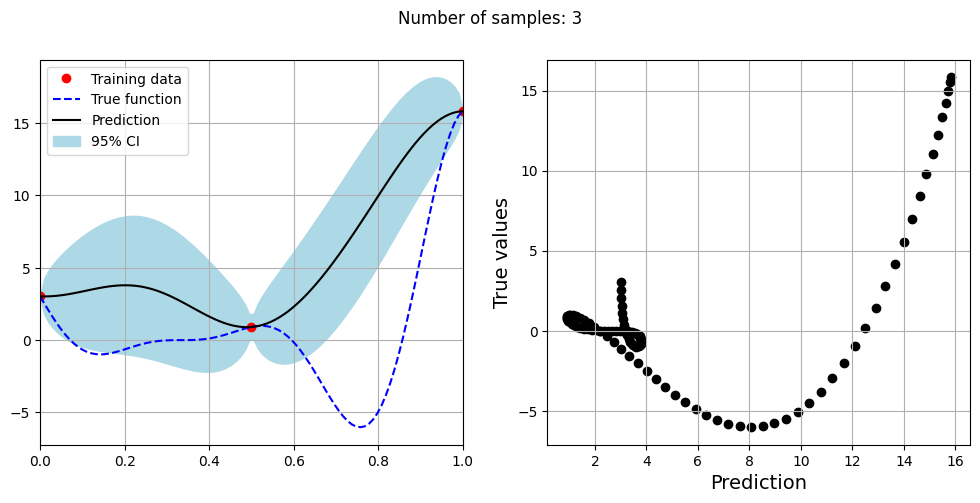

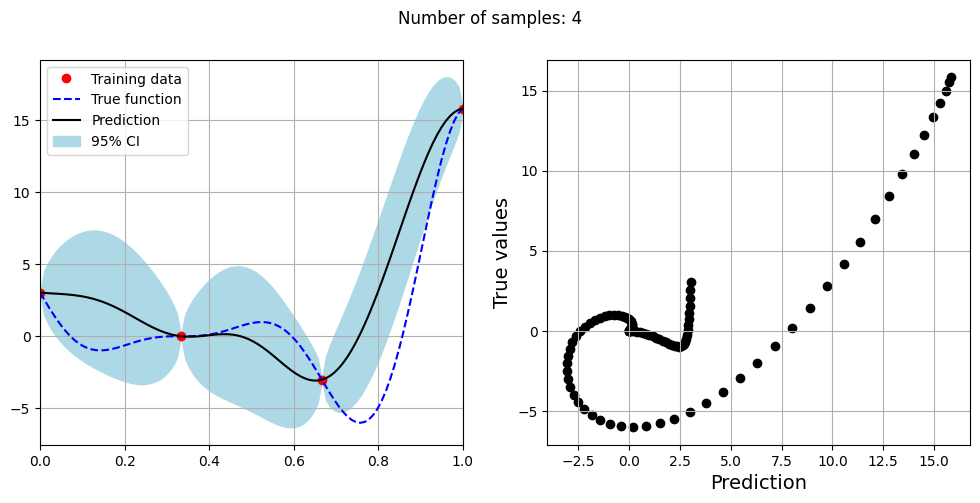

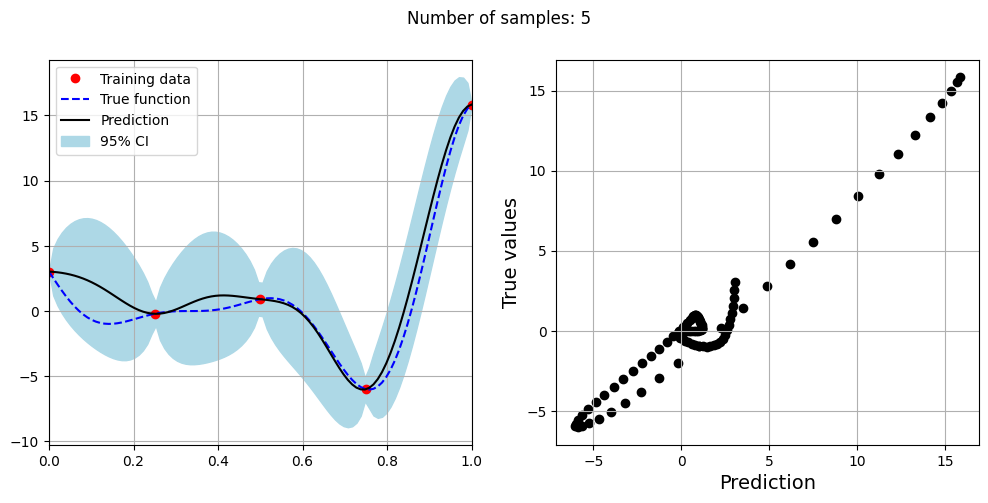

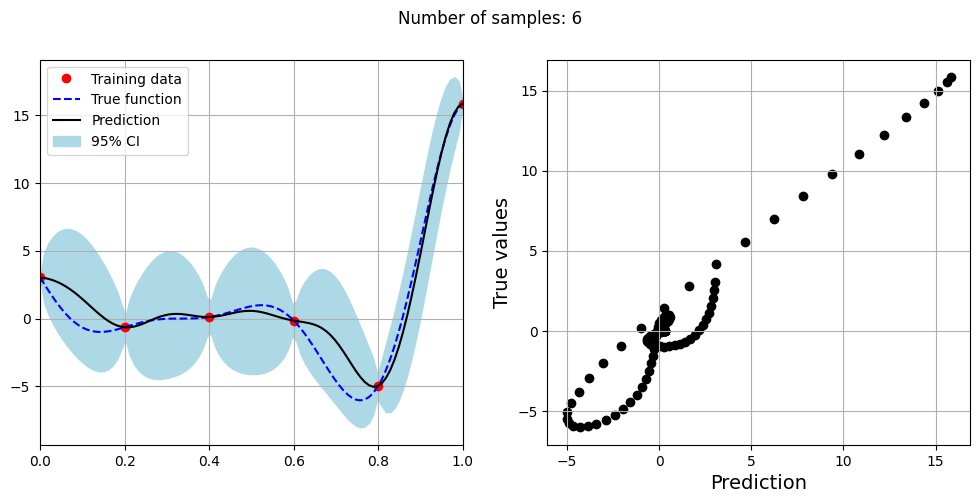

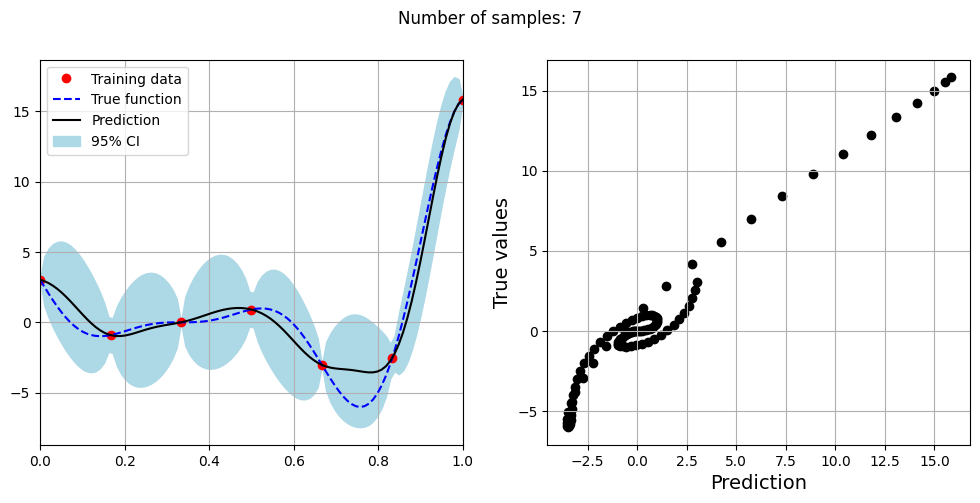

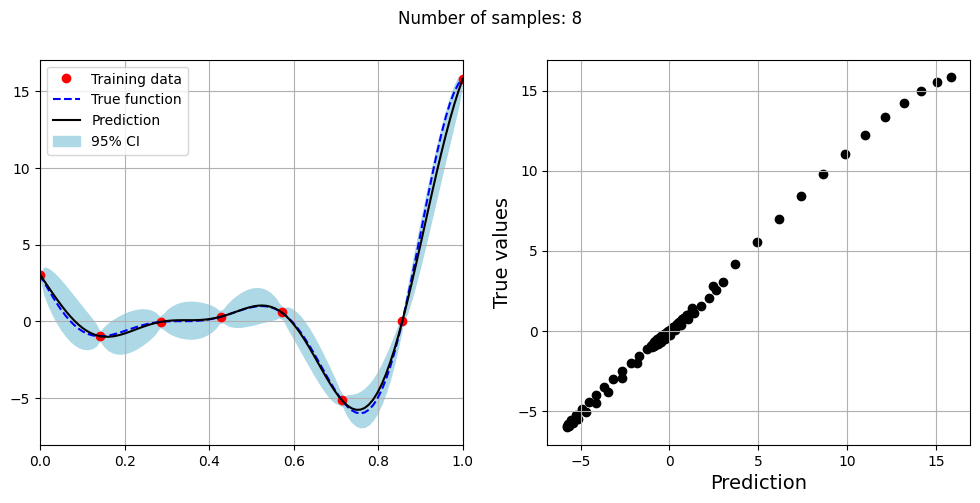

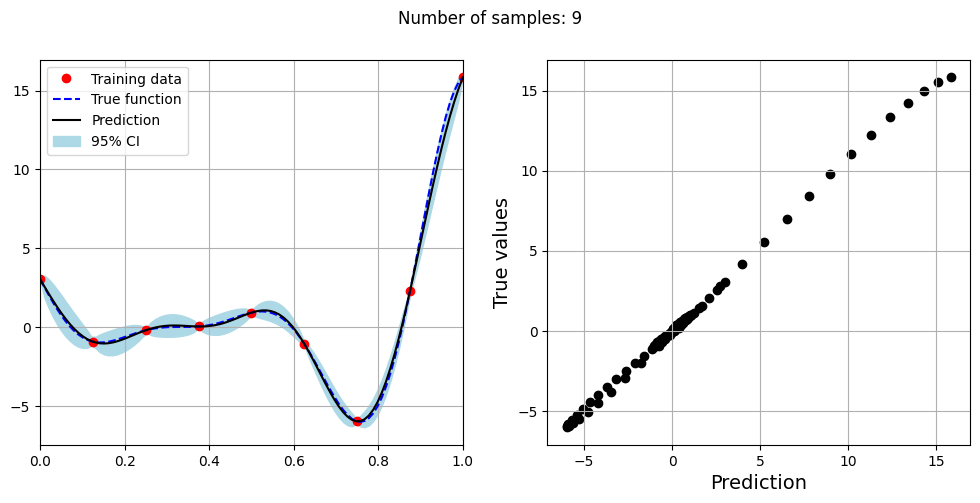

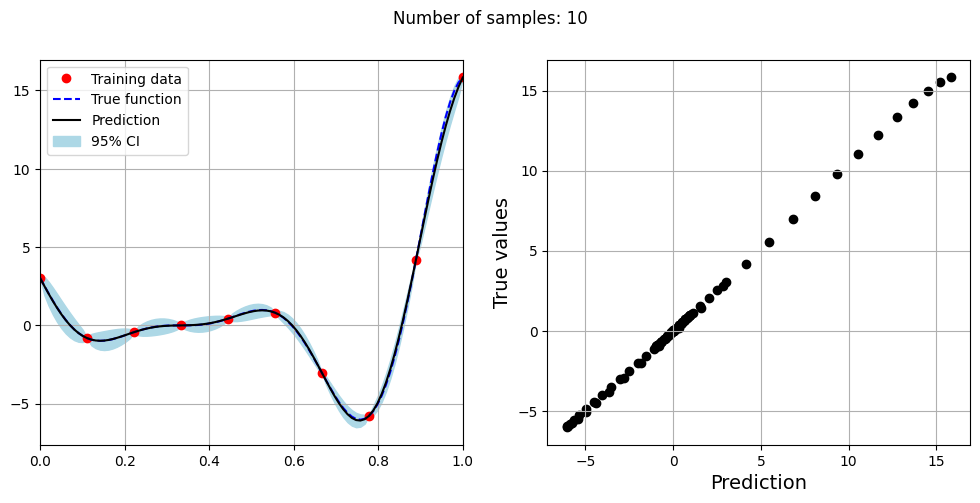

In [23]:
# Creating array of training sample sizes
samples = [3, 4, 5, 6, 7, 8, 9, 10]

# Initializing nrmse list
nrmse = []

# Fitting with different sample size
for sample in samples:
    
    xtrain = torch.linspace(0, 1, sample, **tkwargs)
    ytrain = forrester(xtrain)
    
    # Create model
    gp = SingleOutputGP(x_train=xtrain.reshape(-1,1), y_train=ytrain.reshape(-1,1), output_transform=Standardize, input_transform=Normalize)

    # Defining a few things to train the model
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp) # loss function 
    optimizer = torch.optim.Adam(gp.parameters(), lr=0.01) # optimizer

    # Training the model
    gp.fit(training_iterations=1000, mll=mll, optimizer=optimizer)

    print(f"Optimal lengthscale value for {sample} samples: {gp.covar_module.base_kernel.lengthscale.item()}")

    # Prediction for plotting
    ytest_pred, ytest_std = gp.predict(xtest.reshape(-1,1))

    # Calculating average nrmse
    nrmse.append( evaluate_scalar(ytest, ytest_pred.reshape(-1,), metric="nrmse") )
    
    # Plotting prediction
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(xtrain.numpy(force=True), ytrain.numpy(force=True), 'ro', label='Training data')
    ax[0].plot(xtest.numpy(force=True), ytest.numpy(force=True), 'b--', label='True function')
    ax[0].plot(xtest.numpy(force=True), ytest_pred.numpy(force=True), 'k', label='Prediction')
    ax[0].fill_between(xtest.numpy(force=True), ytest_pred.reshape(-1,).numpy(force=True) - 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), 
                ytest_pred.reshape(-1,).numpy(force=True) + 2*torch.sqrt(ytest_std.reshape(-1,)).numpy(force=True), color='lightblue', label='95% CI')
    ax[0].set_xlim([0, 1])
    plt.xlabel("x", fontsize=14)
    plt.ylabel("y", fontsize=14)
    ax[0].legend(loc="upper left")
    ax[0].grid()
    
    ax[1].scatter(ytest_pred, ytest, c="k")
    ax[1].set_xlabel("Prediction", fontsize=14)
    ax[1].set_ylabel("True values", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Number of samples: {}".format(sample))

As the number of samples increase, the model prediction becomes better. Also, the value of length scale will change with number of samples. So, it is important to refit the model for different data and find the optimal lengthscale. Below block of code plots the normalized RMSE (computed using testing data) as a function of number of samples. The nrmse decreases as the number of samples increase since prediction improves.

Text(0, 0.5, 'Normalized RMSE')

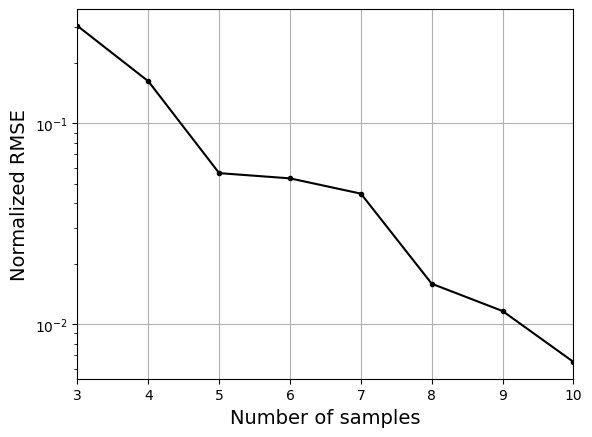

In [24]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".")
ax.grid()
ax.set_yscale("log")
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)